In [ ]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt

# Wind Turbine Proximity Analysis in Berlin

## Project Description

This project analyzes the spatial proximity of wind turbines to urban districts (Bezirksgrenzen) within Berlin, Germany. The goal is to evaluate how close wind energy infrastructure is to residential or administrative centers and to assess potential planning or environmental implications.

## Objective

- Calculate the distance between each wind turbine and the nearest city centroid.
- Visualize wind turbines that are within 5 kilometers of urban districts.
- Create a color-coded map and a histogram showing the distribution of distances.

## Tools and Technologies

- GeoPandas: for geospatial analysis and distance computation
- Folium: for interactive web map visualization
- Shapely: for geometry operations
- Matplotlib: for plotting histogram
- OpenStreetMap and official GeoJSON files for Berlin city boundaries and turbine locations

## Methodology

1. Load wind turbine and city boundary datasets (GeoJSON format).
2. Transform coordinate reference system to EPSG:3857 for accurate distance calculations.
3. Calculate the centroid of each city polygon.
4. Compute the shortest distance from each wind turbine to the nearest city centroid.
5. Filter and highlight turbines within 5 km.
6. Reproject to EPSG:4326 for visualization on a web map.
7. Create an interactive Folium map with color-coded markers:
   - Red for distances < 2 km
   - Orange for distances between 2–5 km
8. Plot a histogram showing the distribution of all computed distances.

## Data Sources

- **Berlin Wind Turbines**  
  Source: [Overpass Turbo](https://overpass-turbo.eu)  
  Query used:
  ```overpass
  [out:json][timeout:25];
  (
    node["power"="generator"]["generator:source"="wind"](52.3, 13.1, 52.7, 13.6);
    way["power"="generator"]["generator:source"="wind"](52.3, 13.1, 52.7, 13.6);
    relation["power"="generator"]["generator:source"="wind"](52.3, 13.1, 52.7, 13.6);
  );
  out body;
  >;
  out skel qt;
- **Berlin District Boundaries (Bezirksgrenzen)**  
  Source: Berlin Open Data Portal – Bezirksgrenzen  
Format: GeoJSON


## Result Summary

- Number of wind turbines within 5 km: X  
- Average distance: Y km  
- Minimum distance: Z₁ km  
- Maximum distance: Z₂ km  

*(Values are printed by the script automatically.)*

## Commentary

A notable number of wind turbines are located within a short range of city districts, which could raise considerations regarding noise, land use, or wildlife impact. This analysis demonstrates a basic but useful way to spatially assess infrastructure placement relative to populated areas.

The study could be expanded by including protected nature zones, bird migration corridors, or noise modeling layers. The interactive map provides a visual and intuitive tool for communicating findings to stakeholders and non-technical audiences.


In [ ]:
# Read wind turbine locations and administrative district boundaries
turbines = gpd.read_file("wind_turbines.geojson").explode(index_parts=False)
cities = gpd.read_file("bezirksgrenzen.geojson").explode(index_parts=False)

# Convert coordinate systems to EPSG:3857 (metric-based, necessary for distance calculations in meters)
turbines = turbines.to_crs(epsg=3857)
cities = cities.to_crs(epsg=3857)

# Calculate the centroid of each city (to approximate city center)
cities['centroid'] = cities.geometry.centroid

# Calculate the minimum distance (in km) from each wind turbine to the nearest city center
turbines['nearest_dist'] = turbines.geometry.apply(
    lambda x: cities['centroid'].distance(x).min() / 1000  # [km] 
)

# Filter wind turbines that are within 5 km of the nearest city center
close_turbines = turbines[turbines['nearest_dist'] <= 5]

# Reproject back to EPSG:4326 for web mapping (Folium requires geographic coordinates in degrees)
close_turbines = close_turbines.to_crs(epsg=4326)

# Create an interactive Folium map centered on Berlin
# Red = <2 km (potential impact), Orange = 2–5 km (moderate buffer)
m = folium.Map(location=[52.52, 13.4], zoom_start=11)
for _, row in close_turbines.iterrows():
    dist = row['nearest_dist']
    if dist < 2:
        color = 'red'
    else:
        color = 'orange'  # 2–5 km arası

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{dist:.2f} km to city"
    ).add_to(m)

# Save the map as an interactive HTML file
m.save("wind_turbines_proximity_final.html")



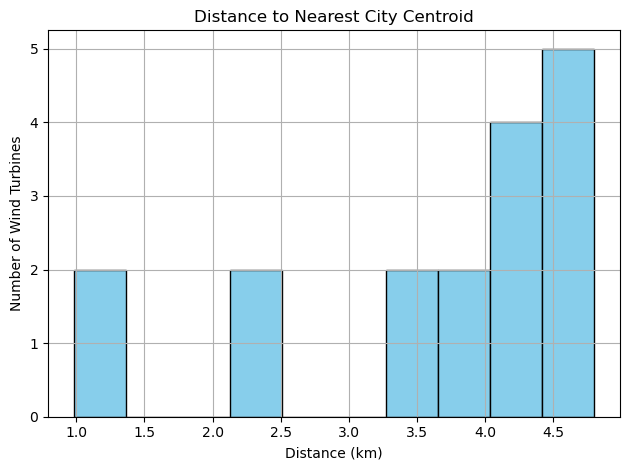

In [ ]:
# Plot a histogram of distances from wind turbines to the nearest city centroid
close_turbines['nearest_dist'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Distance to Nearest City Centroid")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Wind Turbines")
plt.grid(True)
plt.tight_layout()
plt.savefig("distance_histogram.png")
plt.show()


In [16]:
print("Number of wind turbines within 5 km:", len(close_turbines))
print("Average distance:", close_turbines['nearest_dist'].mean(), "km")
print("Minimum distance:", close_turbines['nearest_dist'].min(), "km")
print("Maximum distance:", close_turbines['nearest_dist'].max(), "km")


Number of wind turbines within 5 km: 17
Average distance: 3.6027318429406385 km
Minimum distance: 0.9838264788006651 km
Maximum distance: 4.799892368238902 km
